# paper wrapup - [Attention is All you need](https://arxiv.org/abs/1706.03762)

## Problem

### LSTM, GRU don't scale well

- 기존의 Sequence Modeling을 위해 사용되던 LSTM, GRU는 재귀적 특성(Sequence)으로 인해 병렬화에 제약을 지님
- 이러한 Sequence Length의 증가에 따른 Computation & Memory Complexity를 해결하기 위해 Convolution 기반의 방법 등이 시도되었으나 Long distance의 의존성을 제대로 다룰 수 없었음
  - 예를 임의의 두 위치의 거리에 따라서 
  - ConvS2S는 O(n)
  - ByteNet는 O(logN)
- 즉, long distance의 의존성을 적절하게 다룰 수 있으면서 동시에 sequence에 따른 복잡도를 최소화 할 수 있는 방법의 필요

### Transformers

- Transformer는 두 지점의 거리에 대해서 O(1)의 복잡도를 제공 (Generation의 경우 예외)
- Self-Attention은 Reading Comprehension, Semantic Representation, 등에 뛰어난 성능을 보였음
- Transfomer는 RNN이나 CNN 등을 사용하지 않고 순수하게 Self-Attention만을 사용한 최초의 사례

### Model Architecture

Encoder-Decoder Architecture

#### Encoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - position-wise feedforward (w/ residual connection)

```python

layer_1 = LayerNorm(MultiHeadSelfAttention(x) + x)
layer_2 = LayerNorm(PositionWiseFeedforward(x) + x)

```

#### Decoder

- 6 identical layers
- each layer
  - multi-head self-attention (w/ residual connection)
  - multi-head attention (w/ residual connection)
  - position-wise feedforward (w/residual connection)

```python

layer_1 = LayerNorm(MultiHeadAttention(x) + x)
layer_2 = LayerNorm(MultiHeadAttention(qk: encoder_output, v: x))
layer_3 = LayerNorm(PositionWiseFeedforward(x) + x)

```
  

## Scaled dot-product attention

- Attention의 주요 알고리즘으로 Scaled dot-product attention을 사용
- dot-product
  - attention을 구하는 연산으로 Mat Mul을 사용
- scaled
  - dimension of key and value. 즉, word embedding vector의 dimension dk
  - 1/sqrt(dk)로 attension을 scaling


```python
ScaledDotProduct(Q,K,V) = Softmax(Q@K.T / sqrt(dk))@V
```


In [2]:
import torch

class ScaledDotProductAttention(torch.nn.Module):

    def __init__(self, d_model, device=None, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.dk = torch.sqrt(torch.scalar_tensor(d_model, device=device, dtype=dtype))
    
    def forward(self, q: torch.Tensor, k: torch.Tensor, v: torch.Tensor, mask: torch.Tensor = None) -> torch.Tensor:
        # input should have (B,N,d_model)
        # q (b,1,d_model) , k (b,n,d_model)
        # qk = (b,1,n)
        scaled_qk = q@torch.transpose(k, 2, 1) / self.dk
        if mask is not None:
            scaled_qk = scaled_qk * mask
        attention_weights = torch.softmax(scaled_qk, dim=-1)
        return  attention_weights @  v
        



## Multi-Head attention

- d_model 즉, Query, Key ,Value의 word embedding vector를 다수의 sub vector로 나누어서 각 sub vector를 입력으로 하는 scaled dot-product attention 다수를 조합하여 하나의 Attention block을 구성함.

```python
MultiHeadAttention(Q,K,V,n_heads) = concat(*[ScaledDotProduct(linear(qi),linear(ki),linear(vi)) for qi,ki,vi in zip(Q.split(n_heads), K.split(n_heads), V.split(n_heads))])
```



In [3]:

import torch

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, d_model, n_head, device=None, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.n_head = n_head
        self.depth = d_model // n_head

        self.q_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
        self.k_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
        self.v_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)

        self.attns = torch.nn.ModuleList([ScaledDotProductAttention(d_model=self.depth, device=device, dtype=dtype) for _ in range(n_head)])
        self.output_linear = torch.nn.Linear(d_model, d_model, device=device, dtype=dtype)
                
        
    def forward(self, input: torch.Tensor, mask:torch.Tensor=None) -> torch.Tensor:
        if len(input.shape) == 2:
            input = input.unsqueeze(0)
        if len(input.shape) != 3:
            raise ValueError(f'unsupported tensor shape: {input.shape}, should be form of (B,N,d)')
        
        b,n,d = input.shape
        q = self.q_linear.forward(input).view((b, n, self.n_head, -1))
        k = self.k_linear.forward(input).view((b, n, self.n_head, -1))
        v = self.v_linear.forward(input).view((b, n, self.n_head, -1))
        attn_output = torch.concat([self.attns[i].forward(q[:,:,i,:].view((b,n,self.depth)), 
                                            k[:,:,i,:].view((b,n, self.depth)), 
                                            v[:,:,i,:].view((b,n, self.depth)), mask) for i in range(self.n_head)],dim=-1)
        return self.output_linear.forward(attn_output)
        

In [4]:
import torch


device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
test = torch.rand((1, 1024, 512), device=device, dtype=torch.float16)

attention = MultiHeadAttention(512, 8, device=device, dtype=torch.float16)
attention = torch.compile(attention)




In [5]:
out = attention.forward(test)
out.shape

torch.Size([1, 1024, 512])

## Position-wise feedforward

- Linear - Relu - Linear


## Transformer Layer

- GPT논문의 Transformer layer는 Attention is all you need의 transformer는 Encoder 유사한 구조로 residual connection을 갖는 Multi-head attention과 position wise feedforward의 2개의 sublayer로 구성되어 있고 각 sublayer의 출력에 layer norm이 추가되는 형태
- 첫 GPT 논문에서는 이러한 transformer block 12개를 쌓아 model을 구성


In [31]:
import torch

class PositionWiseFeedforward(torch.nn.Module):

    def __init__(self, d_model:int, device, dtype: torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.pwff = torch.nn.Sequential(torch.nn.Linear(d_model, d_model * 4, device=device,dtype=dtype), 
                                            torch.nn.GELU(), 
                                            torch.nn.Linear(4* d_model, d_model, device=device, dtype=dtype))
        
    def forward(self, input: torch.Tensor)-> torch.Tensor:
        return self.pwff.forward(input)


class Transformer(torch.nn.Module):

    def __init__(self, n_head, d_model, device, dtype:torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.input_norm = torch.nn.LayerNorm(d_model, device=device, dtype=dtype)
        self.mha = MultiHeadAttention(d_model=d_model, n_head=n_head, device=device, dtype=dtype)
        self.mha_lnorm = torch.nn.LayerNorm(d_model, device=device,dtype=dtype)
        self.pw_ff = PositionWiseFeedforward(d_model=d_model, device=device, dtype=dtype)

    def forward(self, input:torch.Tensor, mask: torch.Tensor=None) -> torch.Tensor:
        # Pre-LayerNormalization from GPT-3, (note: Post-LayerNormalization is used for GPT-2 and original paper)
        norm_input = self.input_norm.forward(input)
        mha_output = input + self.mha.forward(norm_input, mask)
        norm_mha_output = self.mha_lnorm(mha_output)
        return mha_output + self.pw_ff.forward(norm_mha_output)


In [32]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transformer = Transformer(8, 512, device=device, dtype=torch.float16)
output = transformer.forward(test)
output.shape

torch.Size([1, 1024, 512])

## Embedding & Tokenization

- Text를 적절한 Numerical Representation으로 변형을 하기 위해서는 크게 2가지의 처리 단계를 필요로 하는데 이는 Tokenization과 Embedding이다.


### Tokenization
- Text를 최소 단위로 쪼개어 각 의미 단위에 고유한 ID를 부여하는 것.
- 최소 단위로 쪼개는 방식에 따라 Character Level Tokenization 부터 Subword Tokenization 등 다양한 방법이 있다. 
- 단, 신규 어휘의 확장에 유연하게 대응할 수 있는 장점을 지닌 Subword 방식을 많이 쓰고 있으며 BPE라는 방식이 유명하다.
  

In [33]:
import torch

vocab_size = 500
dense_rep = 50
batch = 8
seq = 64

input = torch.ones((batch, seq), dtype=torch.int) ## test input

embedding = torch.nn.Embedding(vocab_size, dense_rep) ## convert the token_id to dense vector

output = embedding.forward(input=input)

output.shape # would be (8,64,50)


torch.Size([8, 64, 50])

In [34]:
import lightning as L
from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT

class ToyGPT(L.LightningModule):

    def __init__(self, 
                 vocab_size:int, 
                 d_model:int, n_head:int, num_layers:int, pad_id:int=None,  device=None, dtype:torch.dtype=torch.float, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
        self.embedding = torch.nn.Embedding(vocab_size, d_model, padding_idx=pad_id, device=device, dtype=dtype)
        self.transformers = torch.nn.Sequential(*[Transformer(n_head=n_head, d_model=d_model, device=device, dtype=dtype) for _ in range(num_layers)])
        self.output_linear = torch.nn.Linear(d_model, vocab_size, device=device, dtype=dtype)
        self.softmax = torch.nn.Softmax(dim=-1)


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        # X should have shape of (B,N)
        if len(X.shape) == 1:
            X = X.unsqueeze(0)

        return self.softmax.forward(self.output_linear.forward(self.transformers.forward(self.embedding.forward(input=X))))
    

    def training_step(self, batch_input, batch_index, *args: Any, **kwargs: Any) -> STEP_OUTPUT:

        return super().training_step(*args, **kwargs)
    
    def test_step(self, batch_input, batch_index, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        return super().test_step(*args, **kwargs)

In [35]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

test_input = torch.tensor([0,1,2,3,4,0,0], dtype=torch.int, device=device)

gpt = ToyGPT(5000, 128, n_head=8, num_layers=4, pad_id=0, device=device, dtype=torch.float16)
output = gpt.forward(test_input)
output


tensor([[[1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04],
         [3.1519e-04, 4.2987e-04, 2.3699e-04,  ..., 7.5996e-05,
          4.4417e-04, 1.0359e-04],
         [1.1337e-04, 2.0766e-04, 1.7440e-04,  ..., 7.3850e-05,
          1.2201e-04, 5.0604e-05],
         ...,
         [1.1820e-04, 1.6356e-04, 3.3689e-04,  ..., 9.8586e-05,
          2.1982e-04, 8.1062e-05],
         [1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04],
         [1.9264e-04, 2.3949e-04, 2.5058e-04,  ..., 2.1100e-04,
          1.8418e-04, 1.1563e-04]]], device='cuda:0', dtype=torch.float16,
       grad_fn=<SoftmaxBackward0>)

## `Masking` in Masked Attention


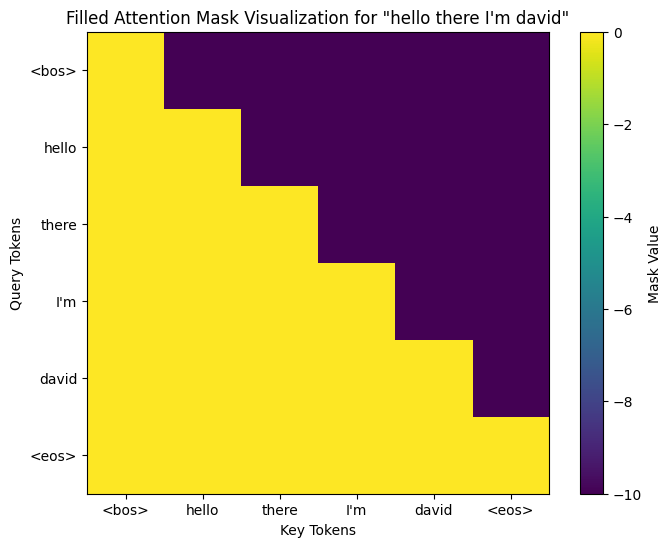

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Example sequence including special tokens
sequence = ["<bos>", "hello", "there", "I'm", "david", "<eos>"]
seq_length = len(sequence)

# Creating a mask with large negative numbers for visualization
filled_mask = np.triu(np.ones((seq_length, seq_length)), k=1) * -10

# Plotting the filled mask
plt.figure(figsize=(8, 6))
plt.imshow(filled_mask, cmap='viridis')
plt.colorbar(label='Mask Value')
plt.title('Filled Attention Mask Visualization for "hello there I\'m david"')
plt.xlabel('Key Tokens')
plt.ylabel('Query Tokens')
plt.xticks(ticks=range(seq_length), labels=sequence)
plt.yticks(ticks=range(seq_length), labels=sequence)
plt.show()



- Masking은 Scaled(Q@K.T)의 결과인 Attention Score에서 QnKm (where m > n)에 있는 값들을 -inf으로 변환한다.
- 이는 GPT와 같은 Autoregressive 모델의 주요한 목적, 즉, Sequence에서 한쪽의 정보를 기반으로 그 다음에 올 정보를 추정해야하는 모델에서 
- 추정의 정답 즉, Ground Truth에 대한 정보가 Training에 포함되는 것을 막기 위함이다.

## Data Preparation
- dataset (27.1 GB)
  - wikimedia/wikipedia', '20231101.en'
  - wikimedia/wikipedia', '20231101.ko'
  - Bingsu/namuwiki_20210301_filtered

- download from huggingface and combine them into single


In [11]:
from typing import List
from datasets import Dataset, load_dataset
from tqdm import tqdm
import json
from unstructured.cleaners.core import replace_unicode_quotes,clean_extra_whitespace, group_broken_paragraphs

dataset_configs = [
    ('wikimedia/wikipedia','20231101.ko'),
    ('wikimedia/wikipedia', '20231101.en'),
    ('Bingsu/namuwiki_20210301_filtered', None)
]

# basic data cleansing
def clean_text(v: str) -> str:
    v = replace_unicode_quotes(v)
    v = clean_extra_whitespace(v)
    v = group_broken_paragraphs(v)
    return v
    


def save_dataset_to_localfile(datasets: List[Dataset], file, rotation=1024*1024*256):
    rotation_id = 0
    id = 0
    for dataset in datasets:
        source = f"{dataset.info.dataset_name}_{dataset.info.config_name}"
        fp = open(f"{file}_{rotation_id}.json", 'w+t', encoding='utf-8')
        fp.write('[')
        first = True
        ova_len = 0

        for data in tqdm(dataset):
            
            obj = {'id': id, 'title': data['title'], 'text': clean_text(data['text']), 'source': source}
            json_str = json.dumps(obj, ensure_ascii=False)
            json_bytes = json_str.encode('utf-8')  # Convert to bytes
            byte_size = len(json_bytes)  # Measure byte size

            if ova_len + byte_size >= rotation:
                fp.write('\n]\n')  # Close the current file
                fp.close()
                rotation_id += 1
                fp = open(f"{file}_{rotation_id}.json", 'w+t', encoding='utf-8')
                fp.write('[')
                first = True
                ova_len = 0
            
            prefix = "\n" if first else ",\n"
            first = False
            fp.write(f"{prefix}{json_str}")
            ova_len += byte_size
            id += 1

        # Handle the end of the dataset
        if ova_len > 0:
            fp.write('\n]\n')
            fp.close()
            first = True

datasets = [load_dataset(dataset_name, config_name, split='train') for dataset_name, config_name in dataset_configs]
save_dataset_to_localfile(datasets, "raw/data", rotation=512*1024*1024)

### Tokenizer

- WordPiece
- Special Tokens
  - `<PAD>`
  - `<BOS>`
  - `<EOS>`
  - `<MASK>`
  - `<CLS>`
  - `<SEP>`
  - `<SYSTEM>`
  - `<ASSISTANT>`
  - `<USER>`
  - `<RESERVE_1 ~ 40>`


  


In [65]:
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer


tokenizer = Tokenizer(WordPiece(unk_token='<UNK>'))
tokenizer.train(['processed/cosmos.json', 'processed/pale_blue_dot.json', 'processed/shakespeare.json'], WordPieceTrainer(vocab_size=30000, special_tokens=[
     "<PAD>","<BOS>","<EOS>", "<MASK>","<CLS>", "<SEP>","<UNK>","<SYSTEM>", "<ASSISTANT>","<USER>", *[f"RESERVE_{i}" for i in range(0,40)]
]))

tokenizer.save('tokenizer.min.json')

# takes too long time, 
# I'll use GPT2 tokenizer instead

In [3]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")


In [53]:
from unstructured.partition.pdf import partition_pdf
from unstructured.cleaners.translate import chunk_by_attention_window
from unstructured.cleaners.core import (
    clean_extra_whitespace, replace_unicode_quotes,
    auto_paragraph_grouper, clean,
    group_broken_paragraphs
)
from unstructured.nlp.partition import is_possible_narrative_text
import re
import json


pattern = r'[\u0080-\u00FF\u2026]'


def clean_line(line:str) -> str:
     line = line.encode('utf-8').decode('unicode-escape')
     return re.sub(pattern, '', clean(replace_unicode_quotes(line), bullets=True, dashes=True)).replace(r'[\u201c\u201d]', '"')

def is_valid_line(line: str) -> bool:
    if len(line.split(' ')) < 2:
        return False
    if not is_possible_narrative_text(line):
        return False
    return True


def convert_pdf_to_json(pdf_path:str, output_path:str, max_window_size:int=512):
    elements = partition_pdf(pdf_path, include_page_breaks=True)
    objs = []
    with open(output_path, 'wt+') as fp:
        raw_text = ''
        for e in elements:
            raw_text += f"{e.text}\n"
        compact_raw = clean_extra_whitespace(auto_paragraph_grouper(group_broken_paragraphs(raw_text)))
        for line in compact_raw.splitlines(keepends=True):
            if not is_valid_line(line):
                continue
            cleaned_line = clean_line(line)
            chunks = chunk_by_attention_window(cleaned_line, tokenizer=tokenizer, max_input_size=max_window_size)
            objs += [{"text": clean_extra_whitespace(c)} for c in chunks]
        json.dump(objs, fp)

def raw_text_to_json(infile: str, outfile: str,  max_window_size:int=512):
    objs = []
    with open(infile, 'rt', encoding='utf-8') as fp:
        raw_text = fp.read()
        compact_raw = clean_extra_whitespace(auto_paragraph_grouper(group_broken_paragraphs(raw_text)))
        for line in compact_raw.splitlines(keepends=True):
            if not is_valid_line(line):
                continue
            cleaned_line = clean_line(line).replace("\u201c", "oe")
            chunks = chunk_by_attention_window(cleaned_line, tokenizer=tokenizer, max_input_size=max_window_size)
            objs += [{"text": clean_extra_whitespace(c)} for c in chunks]
    with open(outfile, 'wt+') as fp:
        json.dump(objs, fp)


In [54]:
convert_pdf_to_json('data/cosmos.pdf', "processed/cosmos.json", max_window_size=512)
convert_pdf_to_json('data/pale_blue_dot.pdf', "processed/pale_blue_dot.json", max_window_size=512)
raw_text_to_json('data/shakespeare.txt', "processed/shakespeare.json", max_window_size=512)

/tmp/ipykernel_35101/4222322516.py:17: DeprecationWarning: invalid escape sequence '\-'
  line = line.encode('utf-8').decode('unicode-escape')


In [2]:
from torch import nn
import torch

# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()

target.shape


torch.Size([3])

In [1]:
from datasets import load_dataset
from transformers import PreTrainedTokenizer, GPT2Tokenizer

dataset = load_dataset('wikimedia/wikipedia', '20231101.en')

def get_tokenizer() -> PreTrainedTokenizer:
    
    tokenizer: PreTrainedTokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({"pad_token": "<pad>", "bos_token":"<s>", "eos_token":"</s>"})
    return tokenizer

/home/fritzprix/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Resolving data files: 100%|██████████| 21/21 [00:00<00:00, 259824.14it/s]


In [2]:
from data import BatchedChunker

new_dataset = dataset["train"].map(BatchedChunker(get_tokenizer(), max_window_size=512), batched=True,num_proc=15)


Map (num_proc=15):   0%|          | 0/6407814 [00:05<?, ? examples/s]


ValueError: The number of tokens in the segment is 742. The maximum number of tokens is 510. Consider using a different split_function to reduce the size of the segments under consideration. The text that caused the error is: 

Related characters Descendants and related characters in the Latin alphabet Æ æ : Latin AE ligature A with diacritics: Å å Ǻ ǻ Ḁ ḁ ẚ Ă ă Ặ ặ Ắ ắ Ằ ằ Ẳ ẳ Ẵ ẵ Ȃ ȃ Â â Ậ ậ Ấ ấ Ầ ầ Ẫ ẫ Ẩ ẩ Ả ả Ǎ ǎ Ⱥ ⱥ Ȧ ȧ Ǡ ǡ Ạ ạ Ä ä Ǟ ǟ À à Ȁ ȁ Á á Ā ā Ā̀ ā̀ Ã ã Ą ą Ą́ ą́ Ą̃ ą̃ A̲ a̲ ᶏ Phonetic alphabet symbols related to A (the International Phonetic Alphabet only uses lowercase, but uppercase forms are used in some other writing systems): Ɑ ɑ : Latin letter alpha / script A, which represents an open back unrounded vowel in the IPA ᶐ : Latin small letter alpha with retroflex hook Ɐ ɐ : Turned A, which represents a near open central vowel in the IPA Λ ʌ : Turned V (also called a wedge, a caret, or a hat), which represents an open mid back unrounded vowel in the IPA Ɒ ɒ : Turned alpha / script A, which represents an open back rounded vowel in the IPA ᶛ : Modifier letter small turned alpha ᴀ : Small capital A, an obsolete or non standard symbol in the International Phonetic Alphabet used to represent various sounds (mainly open vowels) A a ᵄ : Modifier letters are used in the Uralic Phonetic Alphabet (UPA) (sometimes encoded with Unicode subscripts and superscripts) a : Subscript small a is used in Indo European studies ꬱ : Small letter a reversed schwa is used in the Teuthonista phonetic transcription system Ꞻ ꞻ : Glottal A, used in the transliteration of Ugaritic Derived signs, symbols and abbreviations ª : an ordinal indicator Å : Ångström sign ∀ : a turned capital letter A, used in predicate logic to specify universal quantification ("for all") @ : At sign ₳ : Argentine austral Ⓐ : anarchy symbol Ancestors and siblings in other alphabets 𐤀 : Semitic letter Aleph, from which the following symbols originally derive Α α : Greek letter Alpha, from which the following letters derive А а : Cyrillic letter A : Coptic letter Alpha 𐌀 : Old Italic A, which is the ancestor of modern Latin A : Runic letter ansuz, which probably derives from old Italic A : Gothic letter aza/asks Ա ա : Armenian letter Ayb Code points These are the code points for the forms of the letter in various systems 1 Other representations Use as a number In the hexadecimal (base 16) numbering system, A is a number that corresponds to the number 10 in decimal (base 10) counting.

In [33]:
import re
from unstructured.cleaners.core import clean
from transformers import PreTrainedTokenizer, GPT2Tokenizer

def split_into_sentences(text):
    # Regex pattern to split on sentence-ending punctuation followed by space or end of string
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [clean(sentence, extra_whitespace=True, dashes=True, bullets=True) for sentence in sentences]
    


def get_tokenizer() -> PreTrainedTokenizer:
    
    tokenizer: PreTrainedTokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({"pad_token": "<pad>", "bos_token":"<s>", "eos_token":"</s>"})
    return tokenizer

In [34]:
from typing import Any


test = """ AUTHOR OF “A DICTIONARY OF AMERICAN AUTHORS,” “THE
             STORY OF JANE AUSTEN’S LIFE,” “SICUT PATRIBUS
                AND OTHER VERSE,” ETC.; AMERICAN EDITOR
                    OF THE HENRY IRVING SHAKESPEARE,
                                  ETC.




                        [Illustration: Colophon
                                  LEGE
                                  QUID
                                 LEGAS]




                                 BOSTON
                       Sherman, French & Company
                                  1909




                             Copyright 1909
                       SHERMAN, FRENCH & COMPANY




                                 TO THE

                 OLD CAMBRIDGE SHAKESPEARE ASSOCIATION

                                  THIS

                             LITTLE VOLUME

                                   IS

                          GRATEFULLY INSCRIBED




                             PREFATORY NOTE


  The Sixth Act of _The Merchant of Venice_ was first printed in the
  _Cornhill Booklet_ for March, 1903. The _Shakespearean Fantasy_ now
  appears for the first time in print.


I am already far north of London, and as I walk in the streets of
Petersburgh, I feel a cold northern breeze play upon my cheeks, which
braces my nerves and fills me with delight. Do you understand this
feeling? This breeze, which has travelled from the regions towards
which I am advancing, gives me a foretaste of those icy climes.
Inspirited by this wind of promise, my daydreams become more fervent
and vivid. I try in vain to be persuaded that the pole is the seat of
frost and desolation; it ever presents itself to my imagination as the
region of beauty and delight. There, Margaret, the sun is for ever
visible, its broad disk just skirting the horizon and diffusing a
perpetual splendour. There—for with your leave, my sister, I will put
some trust in preceding navigators—there snow and frost are banished;
and, sailing over a calm sea, we may be wafted to a land surpassing in
wonders and in beauty every region hitherto discovered on the habitable
globe. Its productions and features may be without example, as the
phenomena of the heavenly bodies undoubtedly are in those undiscovered
solitudes. What may not be expected in a country of eternal light? I
may there discover the wondrous power which attracts the needle and may
regulate a thousand celestial observations that require only this
voyage to render their seeming eccentricities consistent for ever. I
shall satiate my ardent curiosity with the sight of a part of the world
never before visited, and may tread a land never before imprinted by
the foot of man. These are my enticements, and they are sufficient to
conquer all fear of danger or death and to induce me to commence this
laborious voyage with the joy a child feels when he embarks in a little
boat, with his holiday mates, on an expedition of discovery up his
native river. But supposing all these conjectures to be false, you
cannot contest the inestimable benefit which I shall confer on all
mankind, to the last generation, by discovering a passage near the pole
to those countries, to reach which at present so many months are
requisite; or by ascertaining the secret of the magnet, which, if at
all possible, can only be effected by an undertaking such as mine.

These reflections have dispelled the agitation with which I began my
letter, and I feel my heart glow with an enthusiasm which elevates me
to heaven, for nothing contributes so much to tranquillise the mind as
a steady purpose—a point on which the soul may fix its intellectual
eye. This expedition has been the favourite dream of my early years. I
have read with ardour the accounts of the various voyages which have
been made in the prospect of arriving at the North Pacific Ocean
through the seas which surround the pole. You may remember that a
history of all the voyages made for purposes of discovery composed the
whole of our good Uncle Thomas’ library. My education was neglected,
yet I was passionately fond of reading. These volumes were my study
day and night, and my familiarity with them increased that regret which
I had felt, as a child, on learning that my father’s dying injunction
had forbidden my uncle to allow me to embark in a seafaring life.
""" + ''.join(['hello ' for _ in range(1024)]) + """check that they are OK. Assume that we have modified a typo in the file ~/d2l en/chapter_appendix tools for deep learning/ contributing.md. You can then check which files you have changed. At this point Git will prompt that the chapter_appendix tools for deep learning/ contributing.md file has been modified. mylaptop:d2l en me$ git status On branch master Your branch is up to date with 'origin/master'. Changes not staged for commit: (use \"git add <file>...\" to update what will be committed) (use \"git checkout <file>...\" to discard changes in working directory) modified: chapter_appendix tools for deep learning/contributing.md After confirming that this is what you want, execute the following command: git add chapter_appendix tools for deep learning/contributing.md git commit m 'Fix a typo in git documentation' git push The changed code will then be in your personal fork of the repository. To request the addition of your change, you have to create a pull request for the official repository of the book. Submitting Pull Requests As shown in Fig. B.6, go to your fork of the repository on GitHub and select New pull request. This will open up a screen that shows you the changes between your edits and what is current in the main repository of the book. New pull request. 1060 tFig. B.7 316 317 Tools for Deep Learning Finally, submit a pull request by clicking the button as shown in Fig. B.7. Make sure to describe the changes you have made in the pull request. This will make it easier for the authors to review it and to merge it with the book. Depending on the changes, this might get accepted right away, rejected, or more likely, you will get some feedback on the changes. Once you have incorporated them, you are good to go. Create pull request. B.6.4 Summary (cid:15) You can use GitHub to contribute to this book. (cid:15) You can edit the file on GitHub directly for minor changes. (cid:15) For a major change, please fork the repository, edit things locally, and only""" +  """/**
 * @author  Jamie (jamie.lim@kakaocorp.com)
 * @copyright  Copyright (C) 2018-, Kakao Corp. All rights reserved.
 */


#include "khaiii/Config.hpp"


//////////////
// includes //
//////////////
#include <fstream>

#include "fmt/format.h"
#include "nlohmann/json.hpp"

#include "khaiii/KhaiiiApi.hpp"


namespace khaiii {


using std::exception;
using std::ifstream;
using std::make_shared;
using std::shared_ptr;
using std::string;


/////////////
// methods //
/////////////
void Config::read_from_file(string path) {
    try {
        ifstream ifs(path);
        nlohmann::json jsn;
        ifs >> jsn;
        set_members(jsn);
    } catch (const exception& exc) {
        throw Except(fmt::format("fail to parse config: {}", exc.what()));
    }
}


void Config::override_from_str(const char* opt_str) {
    if (opt_str == nullptr || opt_str[0] == '\0') return;

    try {
        auto jsn = nlohmann::json::parse(opt_str);
        override_members(jsn);
    } catch (const exception& exc) {
        throw Except(fmt::format("fail to parse option: {}\n{}", exc.what(), opt_str));
    }
}


Config* Config::copy_and_override(const char* opt_str) {
    if (opt_str == nullptr || opt_str[0] == '\0') return this;

    auto found = _cfg_cache.find(opt_str);
    if (found != _cfg_cache.end()) return found->second.get();

    auto cfg = copy();
    try {
        auto jsn = nlohmann::json::parse(opt_str);
        cfg->override_members(jsn);
        _cfg_cache[opt_str] = cfg;
    } catch (const exception& exc) {
        throw Except(fmt::format("fail to parse option: {}\n{}", exc.what(), opt_str));
    }

    return cfg.get();
}


void Config::set_members(const nlohmann::json& jsn) {
    class_num = jsn.value("class_num", class_num);
    if (class_num <= 0) throw Except(fmt::format("invalid 'class_num' value: {}", class_num));

    embed_dim = jsn.value("embed_dim", embed_dim);
    if (embed_dim <= 0) throw Except(fmt::format("invalid 'embed_dim' value: {}", embed_dim));

    hidden_dim = jsn.value("hidden_dim", hidden_dim);
    if (hidden_dim <= 0) throw Except(fmt::format("invalid 'hidden_dim' value: {}", hidden_dim));

    vocab_size = jsn.value("vocab_size", vocab_size);
    if (vocab_size <= 0) throw Except(fmt::format("invalid 'vocab_size' value: {}", vocab_size));

    window = jsn.value("window", window);
    if (window <= 0) throw Except(fmt::format("invalid 'window' value: {}", window));

    override_members(jsn);
}

void Config::override_members(const nlohmann::json& jsn) {
    preanal = jsn.value("preanal", preanal);
    errpatch = jsn.value("errpatch", errpatch);
    restore = jsn.value("restore", restore);
}

shared_ptr<Config> Config::copy() {
    auto that = make_shared<Config>();
    that->class_num = class_num;
    that->embed_dim = embed_dim;
    that->hidden_dim = hidden_dim;
    that->vocab_size = vocab_size;
    that->window = window;
    that->preanal = preanal;
    that->errpatch = errpatch;
    that->restore = restore;
    return that;
}


}    // namespace khaiii"""


chunks = split_into_sentences(test)
tokenizer = get_tokenizer()
batch_result = tokenizer.batch_encode_plus(chunks, max_length=512, return_overflowing_tokens=True, truncation=True)
for n, (ids, ovf) in enumerate(zip(batch_result["input_ids"], batch_result["overflowing_tokens"])):
    print(chunks[n], len(ids), ovf)

            
    


AUTHOR OF “A DICTIONARY OF AMERICAN AUTHORS,” “THE STORY OF JANE AUSTEN’S LIFE,” “SICUT PATRIBUS AND OTHER VERSE,” ETC.; AMERICAN EDITOR OF THE HENRY IRVING SHAKESPEARE, ETC. 75 []
[Illustration: Colophon LEGE QUID LEGAS] BOSTON Sherman, French & Company 1909 Copyright 1909 SHERMAN, FRENCH & COMPANY TO THE OLD CAMBRIDGE SHAKESPEARE ASSOCIATION THIS LITTLE VOLUME IS GRATEFULLY INSCRIBED PREFATORY NOTE The Sixth Act of _The Merchant of Venice_ was first printed in the _Cornhill Booklet_ for March, 1903. 99 []
The _Shakespearean Fantasy_ now appears for the first time in print. 16 []
I am already far north of London, and as I walk in the streets of Petersburgh, I feel a cold northern breeze play upon my cheeks, which braces my nerves and fills me with delight. 40 []
Do you understand this feeling? 6 []
This breeze, which has travelled from the regions towards which I am advancing, gives me a foretaste of those icy climes. 27 []
Inspirited by this wind of promise, my daydreams become more 

In [4]:
import re
from unstructured.cleaners.core import clean
from transformers import PreTrainedTokenizer,GPT2Tokenizer
from typing import Any

class SentenceChunker:
    

    def _split_into_sentences(self, text):
        # Regex pattern to split on sentence-ending punctuation followed by space or end of string
        clean_text = clean(text, extra_whitespace=True, dashes=True, bullets=True)
        sentences = re.split(r'(?<=[.!?])\s+', clean_text)
        return [sentence for sentence in sentences]
    
    def __init__(self, tokenizer: PreTrainedTokenizer, max_length:int) -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __call__(self, batch, *args: Any, **kwds: Any) -> Any:
        if isinstance(batch, str):
            batch = [batch]
        batch_of_chunks = [self._split_into_sentences(seq) for seq in batch]
        batch_of_encodings = [self.tokenizer.batch_encode_plus(chunks, return_length=True) for chunks in batch_of_chunks]

        result = {"success": [], "failure": []}
        success_batch_bucket = []
        failure_batch_bucket = []
        for bi, encodings in enumerate(batch_of_encodings):
            bucket = []
            tokens_total = 0
            for n, token_count in enumerate(encodings["length"]):
                if token_count > self.max_length:
                    failure_batch_bucket.append({"text":batch_of_chunks[bi][n], "length": token_count})
                    continue
                if token_count + tokens_total > self.max_length:
                    # bucket is full
                    success_batch_bucket.append({"text":' '.join(bucket), "length": tokens_total})
                    bucket.clear()
                    tokens_total = 0
                    
                bucket.append(batch_of_chunks[bi][n])
                tokens_total += token_count
            result["success"].append([*success_batch_bucket])
            result['failure'].append([*failure_batch_bucket])
            success_batch_bucket.clear()
            failure_batch_bucket.clear()
        return result
                


def get_tokenizer() -> PreTrainedTokenizer:
    
    tokenizer: PreTrainedTokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.add_special_tokens({"pad_token": "<pad>", "bos_token":"<s>", "eos_token":"</s>"})
    return tokenizer

In [3]:
tokenizer = get_tokenizer()
chunker = SentenceChunker(tokenizer, 512)
result = chunker(test)
for c in result["success"][0]:
    print(f"- {c}\n")

result["failure"]
    



NameError: name 'get_tokenizer' is not defined

In [3]:
from datasets import load_dataset



dataset = load_dataset('wikimedia/wikisource', '20231201.en')


Resolving data files: 100%|██████████| 19/19 [00:00<00:00, 176309.24it/s]


In [5]:
tokenizer = get_tokenizer()
chunker = SentenceChunker(tokenizer, 512)

train_dataset = dataset["train"]
n_dataset = train_dataset.map(lambda x: chunker(x["text"]), batched=True, num_proc=15).flatten()

In [6]:
success = n_dataset.select_columns(['success']).flatten()

In [14]:

from typing import Any
from datasets import Dataset, Features, Value
import pyarrow
# def extract_success(dataset: Dataset):
#             for batch in dataset["success"]:
#                 for seq in batch:
#                     yield seq

class SuccessCaseGenerator:
    def __init__(self, dataset: Dataset) -> None:
        self.dataset = dataset

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        for b in self.dataset["success"]:
            for seq in b:
                yield seq

Dataset.from_generator(SuccessCaseGenerator(success))

Generating train split: 1031594 examples [00:09, 109691.18 examples/s]


Dataset({
    features: ['length', 'text'],
    num_rows: 1031594
})